# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Initial Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

Changes:
moved it over to GPU if available
used mish instead of ReLU : result faster convergence, with better accuracy
added tensorboard:


# Importing Libraries

In [15]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.3.1


In [16]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

# Preparing Training and Test Sets

In [17]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']


#make sure data is there
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    #test files go here
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [18]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [19]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [20]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [21]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [22]:
batch_size = 48

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 59
Number of test batches 2


# Data Visualization

In [64]:
class_names = train_dataset.class_names

num_images_to_show=batch_size if batch_size <=8 else 8

#this assummes images, labels and preds are all on same device
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        
        if i>=num_images_to_show:
            break
        plt.subplot(1, num_images_to_show, i + 1, xticks=[], yticks=[])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

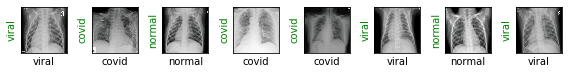

In [65]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [52]:
images.shape

torch.Size([48, 3, 224, 224])

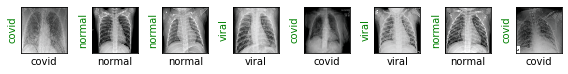

In [53]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

## The original model

In [54]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

## The original model: replace relu with mish
mish is a type of relu with a smoothed, differentiable exponentially decaying negative response

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

#from https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591/7
def convert_relu_to_mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            convert_relu_to_mish(child)

In [56]:
convert_relu_to_mish(resnet18)
#print(resnet18)

# Replace the fully connected bit with one that predicts 3 classes 

In [57]:
from ranger import Ranger
# ranger.__file__

In [58]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# choose generic adam or ranged adam (see Hinton papre)
# optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)
optimizer = Ranger(resnet18.parameters(),betas=(0.9,0.99), eps=1e-6, lr=6e-5)#note the higher learning rate


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


# Put model on GPU if available

In [59]:
resnet18 = resnet18.to(dev)

#print(resnet18)
next(resnet18.parameters())

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [60]:
next(resnet18.parameters()).is_cuda

True

In [44]:
# dev
# images=images.to(dev)
# images.is_cuda

device(type='cuda')

In [66]:
#reconcile with device these are on
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images_cpy = images.clone()#just images not graph related info
    labels_cpy = labels.clone()
    images=images.to(dev)
    labels=labels.to(dev)
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    preds1=preds.clone()
    show_images(images_cpy, labels_cpy, preds)

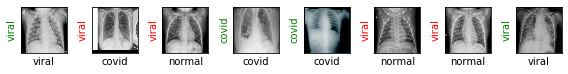

In [67]:
show_preds()

# Training the Model

In [68]:
def train(epochs, showpreds=False):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            images = images.to(dev)      #push to GPU if available
            labels = labels.to(dev)      # "

            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                #lets save some memory
                with torch.no_grad():
                    resnet18.eval() # set model to eval phase

                    for val_step, (images, labels) in enumerate(dl_test):
                        images = images.to(dev) #to gpu if available
    #                     labels1=labels.detach().clone()                
                        labels = labels.to(dev)

                        outputs = resnet18(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()

                        _, preds = torch.max(outputs, 1)
                        accuracy += (sum((preds == labels)).cpu().numpy())

                    val_loss /= (val_step + 1)
                    accuracy = accuracy/len(test_dataset)
                    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                    if showpreds is True:
                        show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [69]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1303, Accuracy: 0.3111
Evaluating at step 20
Validation Loss: 1.5437, Accuracy: 0.5000
Evaluating at step 40
Validation Loss: 0.9719, Accuracy: 0.9444
Training Loss: 0.6001
Training complete..
CPU times: user 3min 15s, sys: 4.1 s, total: 3min 19s
Wall time: 53.7 s


# Final Results

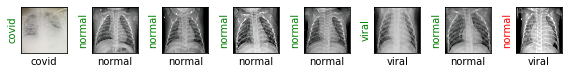

In [70]:
show_preds()